In [4]:
import numpy as np
import ase
import nglview

AttributeError: 'super' object has no attribute '_ipython_display_'

In [21]:
%load_ext autoreload
%autoreload 2
import cpmd
%reload_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
'''
トラジェクトリの読み込み．帰ってくるtrajは自作したcustom_trajクラスで，ase.atomsのリストの他に時間情報やBECなどを保持できる．
ReadPOSを利用した場合にはtraj.timeとすることで時間情報(ps)を見ることができるのでこれを後のフーリエ変換で利用できる．
'''
traj=cpmd.ReadPOS("aiida.pos", "GaAs.3_md.in")

In [23]:
# ReadCP has nglview_traj method to visualize trajectory 
view = traj.nglview_traj()
view

NGLWidget(max_frame=545)

In [28]:
# トラジェクトリの保存(in extxyz)
traj.save()

0

In [29]:
# wannier を利用せずにBECを使う場合は以下のようにBECを用意する必要がある．

BEC1=np.array([
 [ 2.14222,  0.  ,     0.     ],
 [ 0.  ,     2.14222,  0.     ],
 [ 0.  ,     0.  ,     2.14222]
])
BEC2=-BEC1

print(BEC1)
print("")
print(BEC2)

BEC1_super=np.tile(BEC1, (4,1))
BEC2_super=np.tile(BEC2, (4,1))
BECsum=np.concatenate([BEC1_super, BEC2_super])
print(BECsum)

# np.savetxt("BECsum.txt",BECsum)

# for conventional cell
BEC_final=np.tile(BECsum,  (8,1))
print(BEC_final)
# for 2*2*2 supercell
BEC_final2=BEC_final.reshape(64,3,3)
# print(BEC_final2)

[[2.14222 0.      0.     ]
 [0.      2.14222 0.     ]
 [0.      0.      2.14222]]

[[-2.14222 -0.      -0.     ]
 [-0.      -2.14222 -0.     ]
 [-0.      -0.      -2.14222]]
[[ 2.14222  0.       0.     ]
 [ 0.       2.14222  0.     ]
 [ 0.       0.       2.14222]
 [ 2.14222  0.       0.     ]
 [ 0.       2.14222  0.     ]
 [ 0.       0.       2.14222]
 [ 2.14222  0.       0.     ]
 [ 0.       2.14222  0.     ]
 [ 0.       0.       2.14222]
 [ 2.14222  0.       0.     ]
 [ 0.       2.14222  0.     ]
 [ 0.       0.       2.14222]
 [-2.14222 -0.      -0.     ]
 [-0.      -2.14222 -0.     ]
 [-0.      -0.      -2.14222]
 [-2.14222 -0.      -0.     ]
 [-0.      -2.14222 -0.     ]
 [-0.      -0.      -2.14222]
 [-2.14222 -0.      -0.     ]
 [-0.      -2.14222 -0.     ]
 [-0.      -0.      -2.14222]
 [-2.14222 -0.      -0.     ]
 [-0.      -2.14222 -0.     ]
 [-0.      -0.      -2.14222]]
[[ 2.14222  0.       0.     ]
 [ 0.       2.14222  0.     ]
 [ 0.       0.       2.14222]
 [ 2.14222  0. 

In [30]:
# set bec
traj.set_bec(bec=BEC_final2)

# calculate dipole
dipole_array=traj.calc_dipole()


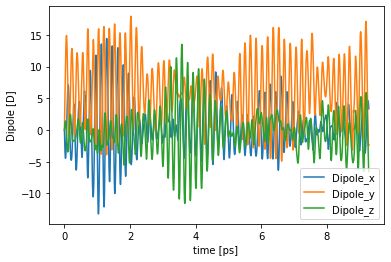

In [62]:
start=1000 # 初めの1000ステップは切り捨てる．
import matplotlib.pyplot as plt
x=np.arange(np.shape(dipole_array)[0]-start)
plot_dipole_array=dipole_array[start:,:]-dipole_array[start,:]
plot_time_array=traj.time[:-start]

plt.plot(plot_time_array,plot_dipole_array[:,0],label="Dipole_x")
plt.plot(plot_time_array,plot_dipole_array[:,1],label="Dipole_y")
plt.plot(plot_time_array,plot_dipole_array[:,2],label="Dipole_z")
plt.xlabel("time [ps] ")
plt.ylabel("Dipole [D]")
plt.legend()

In [63]:
# dipoleの配列，格子定数を渡すとacfを計算してくれる関数（still experimental）
eps_0, acf_x, acf_y, acf_z = cpmd.raw_calc_acf(plot_dipole_array, traj.UNITCELL_VECTOR, start=0, stop=-1, T=300)

 -------------- 
 volume ::  1.4020367104163036e-27

 -------------- 
 nlag   ::  3841


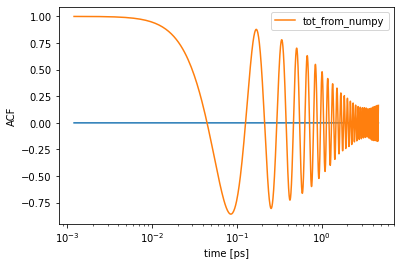

In [64]:
# ACFのプロット
import matplotlib.pyplot as plt
input_data =(acf_x+acf_y+acf_z)/3
plt.plot(traj.time[:len(input_data)],np.zeros(len(input_data)))
plt.plot(traj.time[:len(input_data)],input_data,label="tot_from_numpy")
#sigma=1
#blur_array = gaussian_filter((acf_x+acf_y+acf_z)/3, sigma)
#plt.plot(time[:],blur_array,label="Blur")
plt.legend()
plt.xlabel("time [ps]")
plt.ylabel("ACF")
plt.xscale("log")
plt.show()

In [59]:

# fourier変換
from quadrupole import calc_fourier
eps_n2 = 1.333**2
eps_n2 = 10**2
eps_inf = 1.0
#eps_0 = pred_eps
#data=acfs["acf"].to_numpy()
fft_data =(acf_x+acf_y+acf_z)/3
#data[0]=0.5
#data =blur_array

TIMESTEP =(traj.time[1]-traj.time[0])  # psec.

rfreq, ffteps1, ffteps2=calc_fourier(fft_data,eps_0, eps_n2,TIMESTEP)

kayser = rfreq * 33.3 

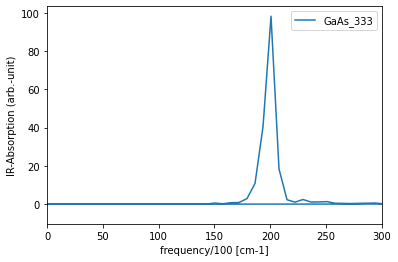

In [60]:
# 変換後の誘電関数の描画

plt.plot(kayser, ffteps2, label="GaAs_333")
plt.legend()
plt.xlabel("frequency/100 [cm-1]")
#plt.xlabel("frequency [THz]")
plt.ylabel("IR-Absorption (arb.-unit)")
plt.xlim(0,300)
#plt.ylim(0,10)
#plt.xscale('log')
#plt.yscale('log')
plt.show()